In [1]:
from random import randint, uniform
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import sklearn
import seaborn as sns
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

dataset = pd.read_csv(r"kc_house_data.csv")
df = pd.DataFrame(dataset)

#check no null values
print(df.isnull().sum())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


C:\Users\Amy\AppData\Local\Temp\ipykernel_18116\1935967357.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'], bins=30)


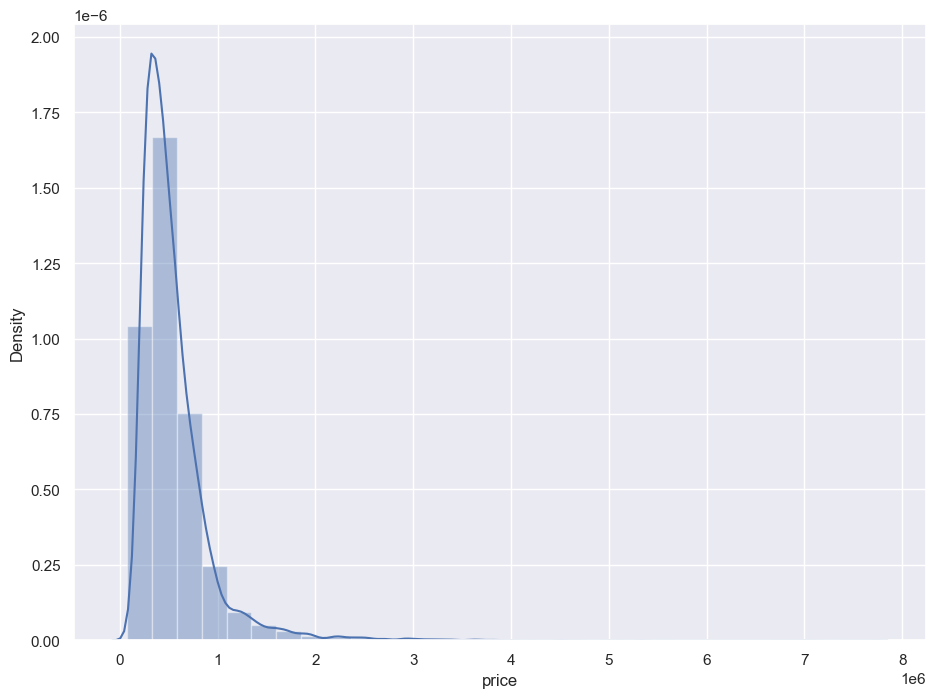

In [2]:
#price distribution
sns.set(rc={'figure.figsize':(11,8)})
sns.distplot(df['price'], bins=30)
plt.show()

In [3]:
#dataset setup
#drop id
X_limit = df.drop(['id'], axis=1)
#shape date
X_limit['date'] = pd.to_datetime(X_limit['date']).dt.year.astype(str)

date             0.00
price            1.00
bedrooms         0.31
bathrooms        0.53
sqft_living      0.70
sqft_lot         0.09
floors           0.26
waterfront       0.27
view             0.40
condition        0.04
grade            0.67
sqft_above       0.61
sqft_basement    0.32
yr_built         0.05
yr_renovated     0.13
zipcode         -0.05
lat              0.31
long             0.02
sqft_living15    0.59
sqft_lot15       0.08
Name: price, dtype: float64


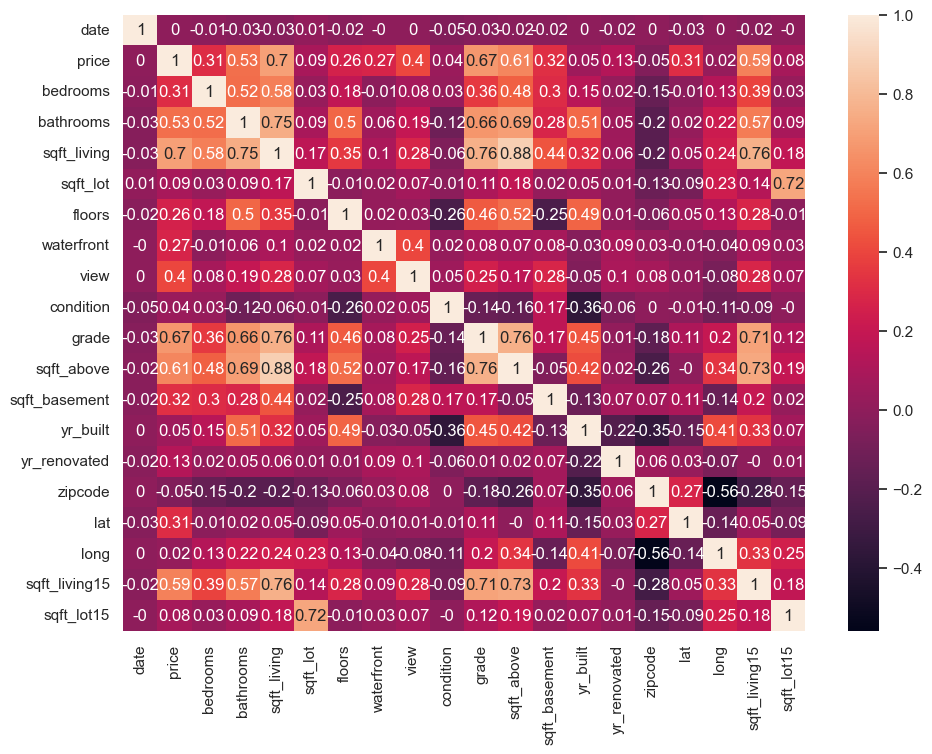

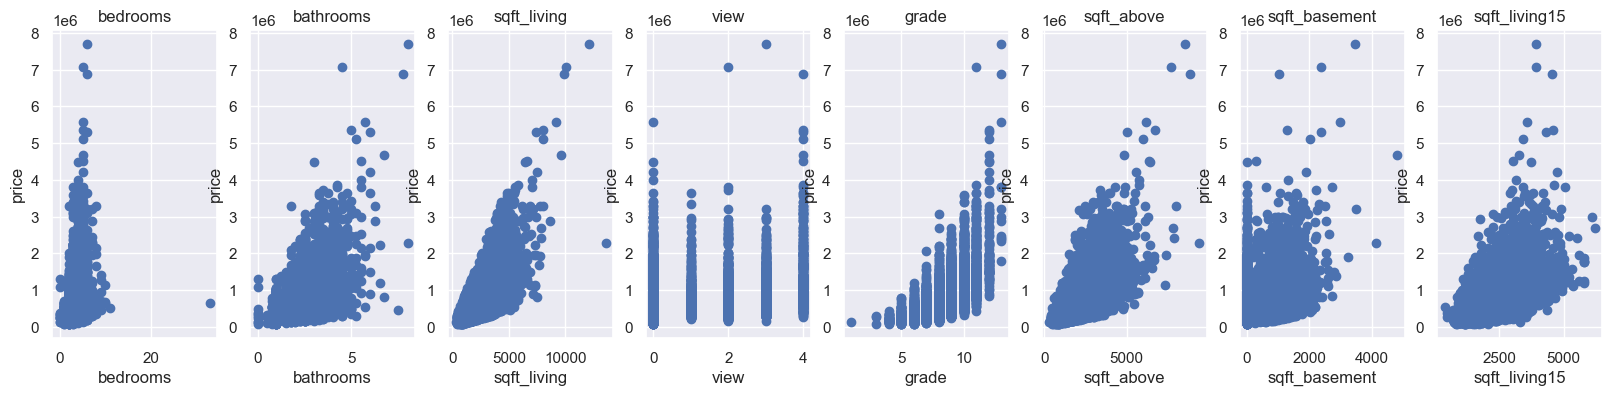

In [4]:
#heatmap
correlation_matrix = X_limit.corr().round(2)
print(correlation_matrix['price'])
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

#show highest correlation features vs price
plt.figure(figsize=(20, 4))
features = ['bedrooms', 'bathrooms','sqft_living','view','grade','sqft_above','sqft_basement', 'sqft_living15']
target = df['price']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price')
plt.show()

In [5]:
#show refined dataset
print(X_limit)

#remove target price from features
X_limit = X_limit.drop(['price'], axis=1)

#shape X and Y
X = X_limit.to_numpy()
Y = df['price'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      2014  221900.0         3       1.00         1180      5650     1.0   
1      2014  538000.0         3       2.25         2570      7242     2.0   
2      2015  180000.0         2       1.00          770     10000     1.0   
3      2014  604000.0         4       3.00         1960      5000     1.0   
4      2015  510000.0         3       2.00         1680      8080     1.0   
...     ...       ...       ...        ...          ...       ...     ...   
21608  2014  360000.0         3       2.50         1530      1131     3.0   
21609  2015  400000.0         4       2.50         2310      5813     2.0   
21610  2014  402101.0         2       0.75         1020      1350     2.0   
21611  2015  400000.0         3       2.50         1600      2388     2.0   
21612  2014  325000.0         2       0.75         1020      1076     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
0  



***Linear Regression***

Train RMSE  = 197627.87650341415
Training R2 = 0.7010486008272694
Test RMSE   = 207816.08676536844
Test R2     = 0.7008480744047468


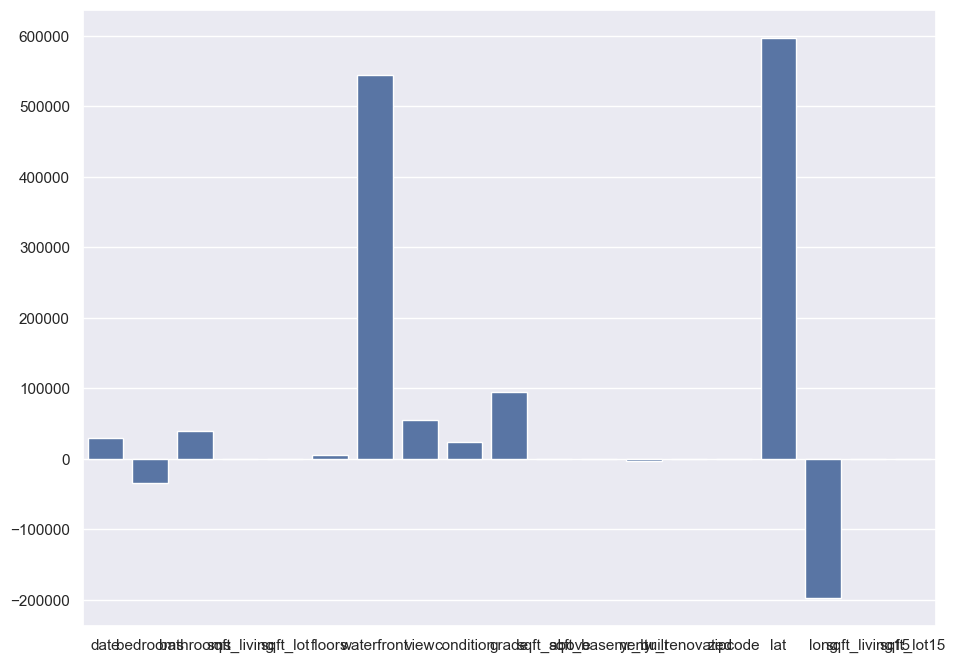

In [6]:
#Linear Regression
print('\n\n***Linear Regression***\n')
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_train = lin_model.predict(X_train)
rmse_train = rmse(y_pred_train, y_train)
r2_train = r2_score(y_train, y_pred_train)
print("Train RMSE  = " + str(rmse_train))
print("Training R2 = " + str(r2_train))

y_pred_test = lin_model.predict(X_test)
rmse_test = rmse(y_pred_test, y_test)
r2_test = r2_score(y_test, y_pred_test)
print("Test RMSE   = " + str(rmse_test))
print("Test R2     = " + str(r2_test))

#plot linear co-efficients
np.set_printoptions(precision=3)  
columns = []
for _ in X_limit.columns:
    columns.append(_)
sns.barplot(x = columns, y=lin_model.coef_)
plt.show()

In [7]:
#NN Regression
print('\n\n***Neural Network Regression***\n')

regr_nn = MLPRegressor(early_stopping=True)

parameter_grid = {
    'hidden_layer_sizes': [(128,),(256,),(512,),(512,512)],
    'alpha': [0.0001, 0.001, 0.01],  
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500,1000,1500]
}
grid = RandomizedSearchCV(regr_nn, param_distributions=parameter_grid, n_iter=10,
                                   cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train,y_train)
best_param = grid.best_params_
print('GridSearch Best Parameters: '+ str(best_param))
best_regr=grid.best_estimator_
best_regr.fit(X_train, y_train)

#fit to best
y_pred_nn_train=best_regr.predict(X_train)
rmse_train_nn = rmse(y_pred_nn_train, y_train)
r2_train_nn = r2_score(y_train, y_pred_nn_train)
print("Train RMSE  = " + str(rmse_train_nn))
print("Training R2 = " + str(r2_train_nn))

y_pred_nn_test=best_regr.predict(X_test)
rmse_test_nn = rmse(y_pred_nn_test, y_test)
r2_test_nn = r2_score(y_test, y_pred_nn_test)
print("Test RMSE   = " + str(rmse_test_nn))
print("Test R2     = " + str(r2_test_nn))



***Neural Network Regression***

GridSearch Best Parameters: {'max_iter': 1000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (512, 512), 'alpha': 0.001}
Train RMSE  = 210264.6045994987
Training R2 = 0.6615951929195809
Test RMSE   = 234180.07393949208
Test R2     = 0.6201314361160399


In [8]:
#kNN Regression
print('\n\n***kNN Regression***\n')

regr_knn = KNeighborsRegressor()

parameter_grid = {
    'n_neighbors': [10, 25, 50, 100],
    'weights': ['uniform','distance'],
    'p': [1,2]
}
grid = GridSearchCV(regr_knn, parameter_grid, cv=7, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train,y_train)
best_param = grid.best_params_
print('GridSearch Best Parameters: '+ str(best_param))
best_regr=grid.best_estimator_
best_regr.fit(X_train, y_train)

#fit to best
y_pred_knn_train=best_regr.predict(X_train)
rmse_train_knn = rmse(y_pred_knn_train, y_train)
r2_train_knn = r2_score(y_train, y_pred_knn_train)
print("Train RMSE  = " + str(rmse_train_knn))
print("Training R2 = " + str(r2_train_knn))

y_pred_knn_test=best_regr.predict(X_test)
rmse_test_knn = rmse(y_pred_knn_test, y_test)
r2_test_knn = r2_score(y_test, y_pred_knn_test)
print("Test RMSE   = " + str(rmse_test_knn))
print("Test R2     = " + str(r2_test_knn))



***kNN Regression***

GridSearch Best Parameters: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Train RMSE  = 3040.555154398017
Training R2 = 0.9999292363943767
Test RMSE   = 260026.073283371
Test R2     = 0.5316535069475103


In [9]:
#Descision Tree Regression
print('\n\n***Descision Tree Regression***\n')

regr_dtr = DecisionTreeRegressor()
#tune hyperparams
parameter_grid = {
    'min_impurity_decrease':[0.05,0.1,0.3,0.5],
    'min_samples_leaf': [8,15,25],
    'max_depth':[8,10,12]
}
grid = GridSearchCV(regr_dtr, parameter_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train,y_train)
best_param = grid.best_params_
print('GridSearch Best Parameters: '+ str(best_param))
best_regr=grid.best_estimator_
best_regr.fit(X_train, y_train)

#fit to best
y_pred_dtr_train=best_regr.predict(X_train)
rmse_train_dtr = rmse(y_pred_dtr_train, y_train)
r2_train_dtr = r2_score(y_train, y_pred_dtr_train)
print("Train RMSE  = " + str(rmse_train_dtr))
print("Training R2 = " + str(r2_train_dtr))

y_pred_dtr_test=best_regr.predict(X_test)
rmse_test_dtr = rmse(y_pred_dtr_test, y_test)
r2_test_dtr = r2_score(y_test, y_pred_dtr_test)
print("Test RMSE   = " + str(rmse_test_dtr))
print("Test R2     = " + str(r2_test_dtr))



***Descision Tree Regression***

GridSearch Best Parameters: {'max_depth': 12, 'min_impurity_decrease': 0.05, 'min_samples_leaf': 8}
Train RMSE  = 115616.23548720423
Training R2 = 0.8976844057736825
Test RMSE   = 165782.77336324094
Test R2     = 0.8096239645009479


In [10]:
#Bagging Tree Regression
print('\n\n***Bagging Tree Regression***\n')

regr_br = BaggingRegressor()
#tune hyperparams
parameter_grid = {
    'n_estimators':[10, 50, 100, 200, 300],
}
grid = GridSearchCV(regr_br, parameter_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train,y_train)
best_param = grid.best_params_
print('GridSearch Best Parameters: '+ str(best_param))
best_regr=grid.best_estimator_
best_regr.fit(X_train, y_train)

#fit to best
y_pred_br_train=best_regr.predict(X_train)
rmse_train_br = rmse(y_pred_br_train, y_train)
r2_train_br = r2_score(y_train, y_pred_br_train)
print("Train RMSE  = " + str(rmse_train_br))
print("Training R2 = " + str(r2_train_br))

y_pred_br_test=best_regr.predict(X_test)
rmse_test_br = rmse(y_pred_br_test, y_test)
r2_test_br = r2_score(y_test, y_pred_br_test)
print("Test RMSE   = " + str(rmse_test_br))
print("Test R2     = " + str(r2_test_br))



***Bagging Tree Regression***

GridSearch Best Parameters: {'n_estimators': 300}
Train RMSE  = 46868.552511156726
Training R2 = 0.9831861463126955
Test RMSE   = 142270.15857068182
Test R2     = 0.8597957726354458


In [11]:
#Boosted Tree Regression
print('\n\n***Boosted Tree Regression***\n')
regr_gbr = GradientBoostingRegressor()
#tune hyperparams
parameter_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
}
grid = GridSearchCV(regr_gbr, parameter_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train,y_train)
best_param = grid.best_params_
print('GridSearch Best Parameters: '+ str(best_param))
best_regr=grid.best_estimator_
best_regr.fit(X_train, y_train)

#fit to best
y_pred_gbr_train=best_regr.predict(X_train)
rmse_train_gbr = rmse(y_pred_gbr_train, y_train)
r2_train_gbr = r2_score(y_train, y_pred_gbr_train)
print("Train RMSE  = " + str(rmse_train_gbr))
print("Training R2 = " + str(r2_train_gbr))

y_pred_gbr_test=best_regr.predict(X_test)
rmse_test_gbr = rmse(y_pred_gbr_test, y_test)
r2_test_gbr = r2_score(y_test, y_pred_gbr_test)
print("Test RMSE   = " + str(rmse_test_gbr))
print("Test R2     = " + str(r2_test_gbr))



***Boosted Tree Regression***

GridSearch Best Parameters: {'n_estimators': 300}
Train RMSE  = 93078.41297161076
Training R2 = 0.9336864738771599
Test RMSE   = 131084.34464251655
Test R2     = 0.8809758382335044
